In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal

## Speed tests

In [20]:
path_200_1 = '/Users/Olivier/Desktop/Mini_Tract/Tests/Data/Delay_Speed/delay_200.txt'
path_200_2 = '/Users/Olivier/Desktop/Mini_Tract/Tests/Data/Delay_Speed/delay_200_2.txt'
path_400 = '/Users/Olivier/Desktop/Mini_Tract/Tests/Data/Delay_Speed/delay_400.txt'
path_2000_1 = '/Users/Olivier/Desktop/Mini_Tract/Tests/Data/Delay_Speed/delay_2000.txt'
path_2000_2 = '/Users/Olivier/Desktop/Mini_Tract/Tests/Data/Delay_Speed/delay_2000_2.txt'
path_4000 = '/Users/Olivier/Desktop/Mini_Tract/Tests/Data/Delay_Speed/delay_4000.txt'
path_8000 = '/Users/Olivier/Desktop/Mini_Tract/Tests/Data/Delay_Speed/delay_8000.txt'

delays = ['200', '200', '400', '2000', '2000', '4000', '8000']
paths = [path_200_1, path_200_2, path_400, path_2000_1, path_2000_2, path_4000, path_8000]

DFs = [pd.read_csv(path, sep=' ', names = ['distance', 'time']) for path in paths]
for df in DFs:
    df['time'] = (df['time'] - df['time'].min())/1000

Compute the speed for each test : 
$V = \frac{dx}{dt}$

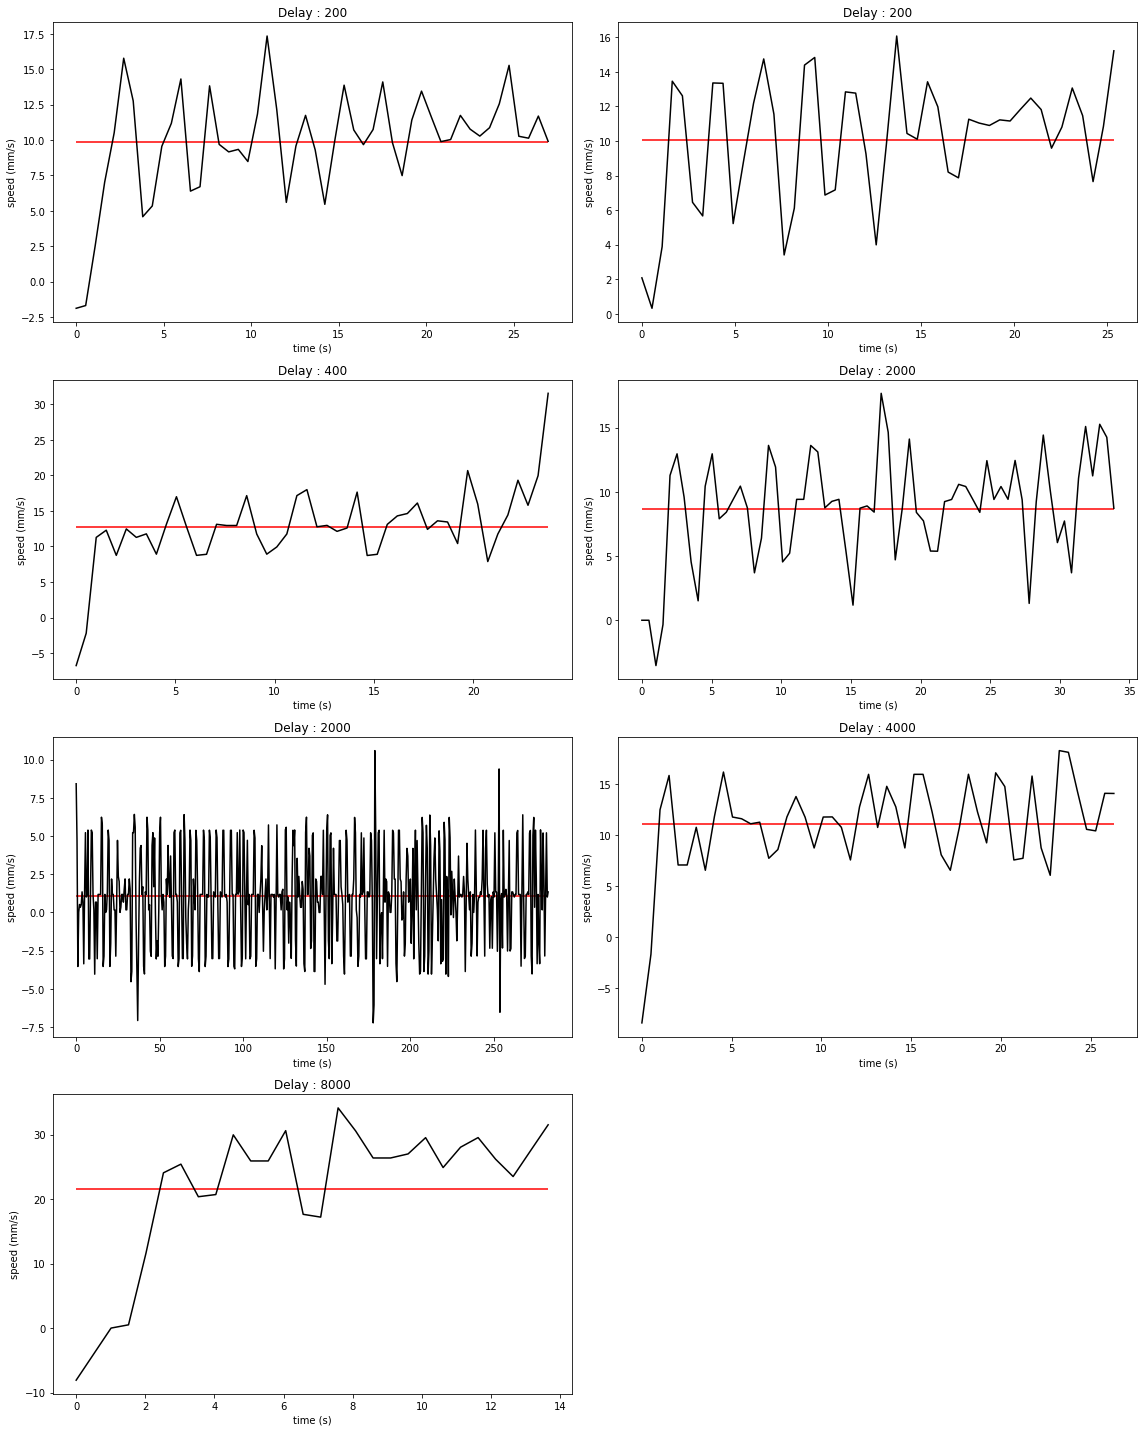

In [28]:
for df in DFs:
    df['speed'] = np.gradient(df['distance'], df['time'])

fig, axes = plt.subplots(4,2, figsize=(16,20))
axes = [ax for ax in axes.reshape(1,-1)[0]]

for df, delay, ax in zip(DFs, delays, axes):
    ax.plot(df['time'], df['speed'], c='k')
    ax.hlines(df['speed'].mean(), df['time'].min(), df['time'].max(), color='r')
    ax.set_title('Delay : ' + delay)
    ax.set_xlabel('time (s)')
    ax.set_ylabel('speed (mm/s)')
axes[-1].set_visible(False)
plt.tight_layout()

In [38]:
# Results Table
Speeds = np.array([df['speed'].mean() for df in DFs])
int_delays = np.array([int(delay) for delay in delays])
data = np.hstack([Speeds, int_delays]).reshape(2, -1)
nice_df = pd.DataFrame(data = data, index = ['speed', 'delay'])
nice_df

,0,1,2,3,4,5,6
speed,9.859876,10.078156,12.771434,8.693626,1.051433,11.076166,21.534246
delay,200.000000,200.000000,400.000000,2000.000000,2000.000000,4000.000000,8000.000000


Speed can range from 1 mm/s to ~20 mm/s

## Flax composite sample tensile test

In [130]:
# Read the data
file_flax_1 = '/Users/Olivier/Desktop/Mini_Tract/Tests/Data/Delay_Speed/test_flax_1.txt'
file_flax_2 = '/Users/Olivier/Desktop/Mini_Tract/Tests/Data/Delay_Speed/test_flax_2.txt'
file_flax_ref = '/Users/Olivier/Python_WD/ASTMD/Tension/0_1.txt'

flax1 = pd.read_csv(file_flax_1, sep=' ', names = ['distance', 'force'])
flax2 = pd.read_csv(file_flax_2, sep=' ', names = ['distance', 'force'])
flax3 = pd.read_csv(file_flax_ref, delim_whitespace=True, skiprows=5, engine='python')  # read data from file
flax3 = flax3.drop(0)  # remove the units
flax3 = flax3.astype(float)

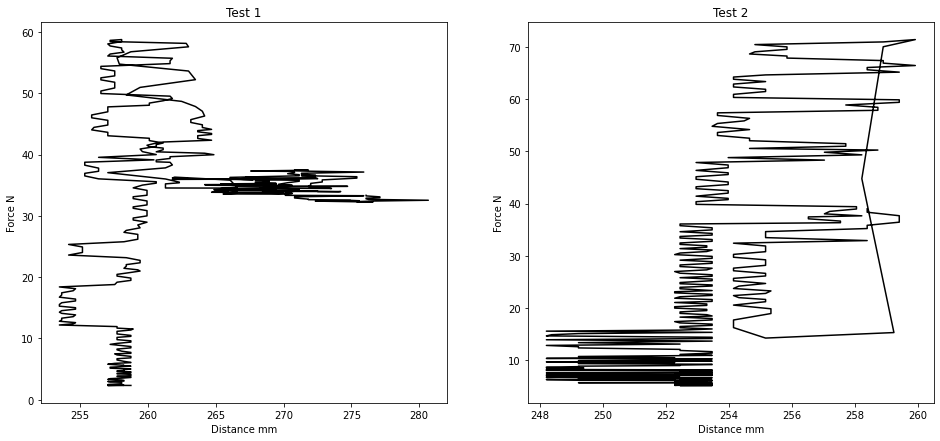

In [131]:
# First plot of the data
plt.figure(figsize=(16,7))
plt.subplot(121)
plt.plot(flax1['distance'], flax1['force'], color='k')
plt.xlabel('Distance mm')
plt.ylabel('Force N')
plt.title('Test 1')
plt.subplot(122)
plt.plot(flax2['distance'], flax2['force'], color='k')
plt.xlabel('Distance mm')
plt.ylabel('Force N')
plt.title('Test 2')
plt.show()

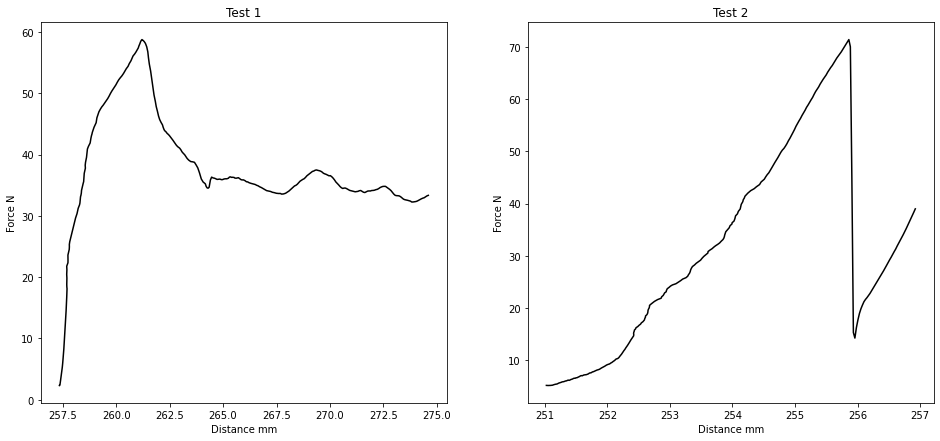

In [132]:
# Apply a filter on the distance
flax1['distance2'] = scipy.signal.savgol_filter(flax1['distance'], 201, 1)
flax2['distance2'] = scipy.signal.savgol_filter(flax2['distance'], 201, 1)

plt.figure(figsize=(16,7))
plt.subplot(121)
plt.plot(flax1['distance2'], flax1['force'], color='k')
plt.xlabel('Distance mm')
plt.ylabel('Force N')
plt.title('Test 1')
plt.subplot(122)
plt.plot(flax2['distance2'], flax2['force'], color='k')
plt.xlabel('Distance mm')
plt.ylabel('Force N')
plt.title('Test 2')
plt.show()

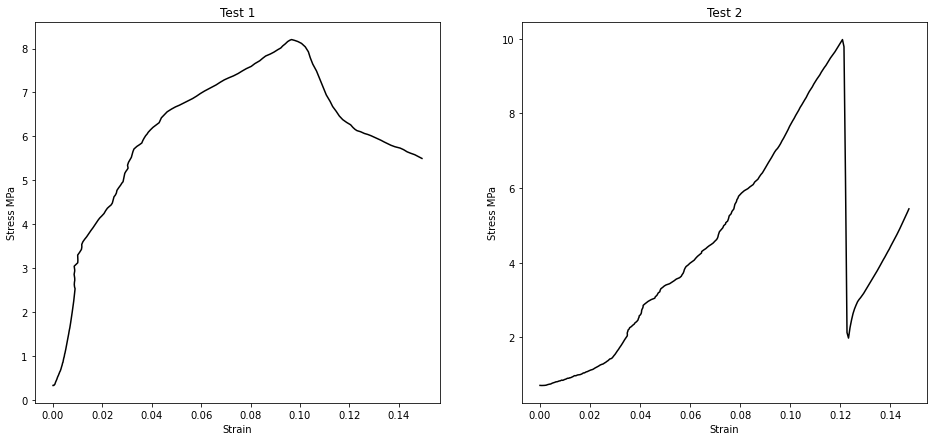

In [162]:
# Compute the stress and strain
width = 12.14 # mm
thick = 0.59 # mm
flax1['Strain'] = (flax1['distance2'] - flax1['distance2'][0]) / 40
flax2['Strain'] = (flax2['distance2'] - flax2['distance2'][0]) / 40
flax1['Stress'] = flax1['force'] / (width*thick) # MPa
flax2['Stress'] = flax2['force'] / (width*thick) # MPa

plt.figure(figsize=(16,7))
plt.subplot(121)
plt.plot(flax1['Strain'], flax1['Stress'], color='k')
plt.xlabel('Strain')
plt.ylabel('Stress MPa')
plt.title('Test 1')
plt.subplot(122)
plt.plot(flax2['Strain'], flax2['Stress'], color='k')
plt.xlabel('Strain')
plt.ylabel('Stress MPa')
plt.title('Test 2')
plt.show()

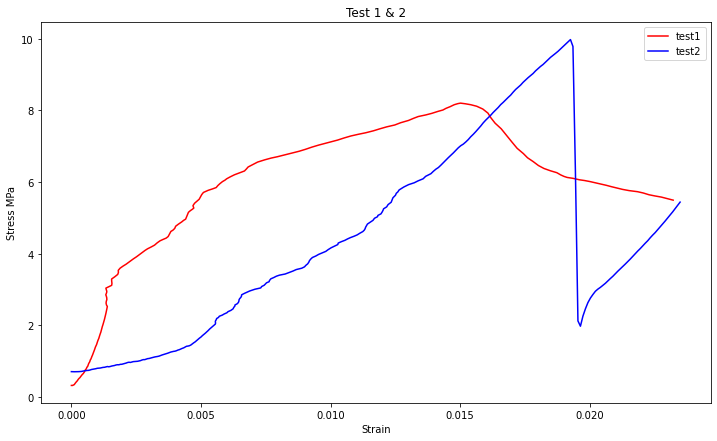

In [134]:
# Trim them so they can be plotted together
max_strain = np.min([flax1['Strain'].max(), flax2['Strain'].max()])
flax1 = flax1.drop(flax1[flax1['Strain']>max_strain].index)
flax2 = flax2.drop(flax2[flax2['Strain']>max_strain].index)

plt.figure(figsize=(12,7))
plt.plot(flax1['Strain'], flax1['Stress'], color='r', label='test1')
plt.plot(flax2['Strain'], flax2['Stress'], color='b', label='test2')
plt.xlabel('Strain')
plt.ylabel('Stress MPa')
plt.title('Test 1 & 2')
plt.legend()

plt.show()

**Test 1 is rejected because there was slippage**

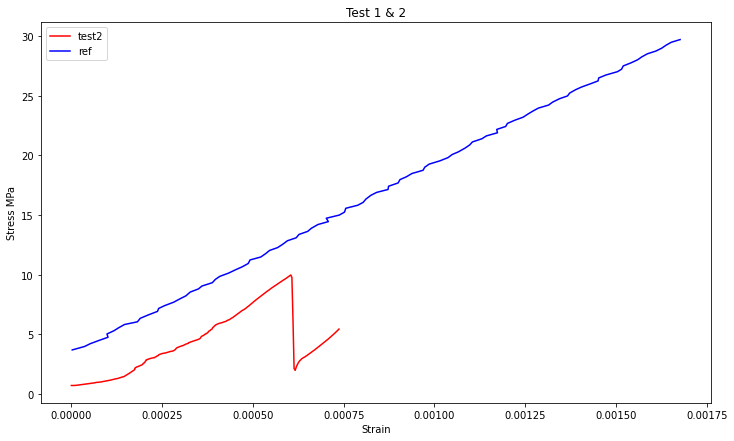

In [169]:
# Compare Test 2 with the reference

# Trim the reference
flax3_trimmed = flax3.drop(flax3[(flax3['Stress']>(flax2['Stress'].max())+200)].index)
flax3_trimmed = flax3

# Compute Strain for reference
flax3['Strain'] = flax3['Extensometer'] / (25.4*2)

# Plot
plt.figure(figsize=(12,7))
plt.plot(flax2['Strain']/200, flax2['Stress'], color='r', label='test2')
plt.plot(flax3_trimmed['Strain'][:100], flax3_trimmed['Stress'][:100], color='b', label='ref')
plt.xlabel('Strain')
plt.ylabel('Stress MPa')
plt.title('Test 1 & 2')
plt.legend()

plt.show()

In [170]:
# Modulus
E_test1 = np.mean(np.gradient(flax2['Stress'][175:250], flax2['Strain'][175:250]))
print(E_test1, 'MPa')
E_ref = np.mean(np.gradient(flax3_trimmed['Stress'][:100], flax3_trimmed['Strain'][:100]))
print(E_ref, 'MPa')

13303.664921800493 MPa
21856.024341196757 MPa


In [172]:
flax3_trimmed['Extensometer']

1      0.000120
2      0.001857
3      0.002632
4      0.003871
5      0.005125
         ...   
837    0.675947
838    0.676591
839    0.677887
840    0.678901
841    0.630001
Name: Extensometer, Length: 841, dtype: float64